In [2]:

import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state, geo_search
from ACS_data import colname_mask
import re
import pickle
import requests
import copy
import censusdata
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy

import statsmodels.api as sm

import plotly.express as px


In [9]:
g = censusdata.censusgeo([('state', '*'), ('county', '*')])

In [8]:
df = pd.read_csv('merged_df.csv', index=False)
#df = df.loc[:,['county_name','State','per_capita', 'population', 'amount']]

In [11]:
topics_list = ['industry', 'race', 'computer', 'poverty',
               'educaction', 'health', 'insurance', 'unemployed', 
               'housing', 'people', 'government', 'families']

variable_list = []
acs_name_dict = {}

def search_acs(subject):
    search = censusdata.search('acs5', 2019, 'concept', subject)
    var_list = [i[0] for i in search]
    var_names = [i[1]+i[2] for i in search]
    return var_list

def acs_name_map(subject, acs='acs5', year=2019):
    search = censusdata.search(acs, year, 'concept', subject)
    var_list = [i[0] for i in search]
    var_names = [i[1]+i[2] for i in search]
    acs_name_dict = {var_list[i]:var_names[i] for i in range(len(var_list))}
    return acs_name_dict


for i in topics_list:
    tmp = search_acs(i)
    variable_list+=tmp
    acs_name_dict = {**acs_name_dict, **acs_name_map(i)}


In [12]:
def get_data_by_subject(subject, topx=50, acs='acs5', year=2019, g=g):
    
    search = censusdata.search('acs1', year, 'concept', subject)#[:topx]
    var_list = [i[0] for i in search]
    var_names = [i[1]+i[2] for i in search]
    # Using ACS5 here for completeness sake, will always assume to left merge at a later date
    tmp_df = censusdata.download(acs, year, g, var_list, key=None, tabletype='detail', endpt='')
    rename = dict(zip(tmp_df.columns, var_names))
    tmp_df = tmp_df.rename(columns =rename)
    tmp_df = tmp_df.reset_index()
    tmp_df['county_name'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[0])
    tmp_df['State'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[1][1:])
    tmp_df['State'] = tmp_df['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
    tmp_df = tmp_df.drop(columns=['index'])
    
    
    return tmp_df

def get_data_by_varlist(varlist, acs='acs5', year=2019, g=g):
    
    var_list = varlist
    #var_names = [i[1]+i[2] for i in search]
    tmp_df = censusdata.download(acs, year, g, var_list, key=None, tabletype='detail', endpt='')
    rename = dict(zip(tmp_df.columns, var_list))
    tmp_df = tmp_df.rename(columns =rename)
    tmp_df = tmp_df.reset_index()
    tmp_df['county_name'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[0])
    tmp_df['State'] = tmp_df['index'].apply(lambda x: str(x).split(':')[0].split(',')[1][1:])
    tmp_df['State'] = tmp_df['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
    tmp_df = tmp_df.drop(columns=['index'])
    
    return tmp_df

def explore_plots(plots_df,df=df):
    joined = df.merge(plots_df, how='left', on=['county_name','State'])
    for i in joined.columns:
        if i not in ['county_name', 'State', 'per_capita']:
            y = np.log(joined[i].astype(float))
            x = np.log(joined['per_capita'])
            plt.scatter(x,y)
            plt.title(i)
            plt.show()
            
def get_proba(col_name, joined):
    model = KernelDensity(bandwidth=1, kernel='gaussian')
    sample = np.array(np.log(joined[col_name]+0.00000001))
    sample = np.array([np.nanmean(sample) if np.isnan(i) else i for i in sample])
    sample = sample.reshape((len(sample), 1))
    model.fit(sample)
    values = np.linspace(0, max(sample)[0], 100)
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    return probabilities

def get_KL(col_name, joined):
    pop = get_proba('population')
    col = get_proba(col_name)
    KL = entropy(pk=pop, qk=col)
    return KL
    

In [ ]:
%%time
KL_list = []
new_varlist = []
df = pd.read_csv('merged_df.csv')
print('Starting census query')
tmp_df = get_data_by_varlist(variable_list)
print('Census query complete')
joined = df.merge(tmp_df, how='left', on=['county_name', 'State'])



'''
for j in joined.columns[32:]:
    if j not in ['county_name', 'State', 'per_capita', 'Unnamed: 0', 'population']:
        if joined.dtypes[j]!=object:
            try:
                new_varlist.append(j)
                KL_list.append(get_KL(j, joined=joined))
            except ValueError as e:
                print(j)
                continue

KL_df = pd.DataFrame({'KL_Divergence':KL_list,
                     'variable_code':new_varlist})
'''


Starting census query


In [ ]:
data = joined.dropna(axis =1)
data = data.select_dtypes(exclude=['object'])

In [ ]:
print(data.shape)
data.dropna(axis=0).shape

In [13]:
joined.to_csv('ACS5k_plus.csv')

In [5]:
joined  = pd.read_csv('ACS5k_plus.csv')

In [9]:
df.head()

Unnamed: 0  employed people with 16 yrs and over  \
0           0                                  8760   
1           1                                 12426   
2           3                                351926   
3           4                                  5636   
4           5                                  5978   

   unemployed people with 16 yrs and over  people in the labor force  \
0                                     525                       9285   
1                                     738                      13164   
2                                   19357                     371283   
3                                     259                       5895   
4                                     414                       6392   

   unemployment rate  people with private health insurance  \
0                5.7                                 11692   
1                5.6                                 19106   
2                5.2                                519407   
3                4.4                                  8251   
4                6.5                                  8556   

   people with public health insurance  people without health insurance  \
0                                 9395                             1644   
1                                 9777                             1154   
2                               186251                            46304   
3                                 6813                              752   
4                                 4952                              675   

   people with a disability    male  ...  State     tot  countyFIPS  \
0                    3527.0   11469  ...     IL   22731     17051.0   
1                    3917.0   14298  ...     IL   30037     17107.0   
2                   62508.0  350466  ...     IL  751962     17097.0   
3                    2892.0    6714  ...     IL   15816     17127.0   
4                    1603.0    6236  ...     IL   14183     17017.0   

   StateFIPS  2021-03-21        amount  shape_code  population  per_capita  \
0       17.0      3078.0  7.432173e+06       18041     23102.0      321.71   
1       17.0      3380.0  3.256686e+07       54045     32019.0     1017.11   
2       17.0     61355.0  3.344544e+09       17097    696535.0     4801.69   
3       17.0      1303.0  1.487627e+07       17127     13772.0     1080.18   
4       17.0      1903.0  1.557705e+07       17017     12147.0     1282.38   

   award_count  
0        411.0  
1        723.0  
2      37781.0  
3        466.0  
4        555.0  

[5 rows x 32 columns]

In [60]:
from scipy.stats.stats import pearsonr
corr_coefs = []
column = []
p_val = []
for i in data.columns:
    if i not in ['per_capita', 'population']:
        if len(data[i].shape)!=2:
        #print(data['per_capita'].shape)
            first_term = data[i]
            
            # Maybe log it, but doesnt matter
            #first_term = np.log(first_term)
            #first_term = np.array([np.mean(first_term[np.isfinite(first_term)]) if np.isinf(i) else i for i in first_term])
            #first_term = np.array([np.mean(first_term[~np.isnan(first_term)]) if np.isnan(i) else i for i in first_term])
            #second_term = np.log(data['per_capita'])
            #try:
            second_term = data['amount']
            pearson = pearsonr(first_term, second_term)
            corr_coefs.append(pearson[0])
            column.append(i)
            p_val.append(pearson[1])
            #except:
                #print()
                #print(sum(np.isinf(first_term)))
                #print(sum(np.isnan(first_term)))
                #print(sum(np.isinf(second_term)))
                #print(sum(np.isnan(second_term)))
                
new_df = pd.DataFrame({'column_name':column,
                     'corr_coefs':corr_coefs,
                      'p_val':p_val})




/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficent is not defined.



In [61]:
name_check = re.compile('[A-Z][0-9]{5}_[0-9]{3}[A-Z]')

new_df['census_name'] = new_df['column_name'].apply(lambda x: acs_name_dict[x] if re.search(name_check, x) else x)

In [62]:
new_df = new_df.sort_values('corr_coefs', ascending=False).reset_index().drop(columns='index')
new_df.head(20)

column_name  corr_coefs          p_val  \
0         amount    1.000000   0.000000e+00   
1    C27014_007E    0.713213   0.000000e+00   
2    C27013_004E    0.669752   0.000000e+00   
3    C24070_051E    0.601473  9.380452e-292   
4    B17001_058E    0.598240  7.578275e-288   
5    C24030_046E    0.596559  7.833551e-286   
6    B17013_006E    0.595200  3.261632e-284   
7    C24040_046E    0.593491  3.459529e-282   
8    B17013_007E    0.590831  4.649555e-279   
9    C27014_002E    0.590629  8.019009e-279   
10   B17001_049E    0.588987  6.608065e-277   
11   C27012_020E    0.588532  2.231248e-276   
12   B17001_059E    0.586538  4.526195e-274   
13   B17003_022E    0.586184  1.157854e-273   
14   B17013_002E    0.585697  4.214685e-273   
15   B17022_077E    0.584826  4.212731e-272   
16   B17003_019E    0.584238  1.987726e-271   
17   C24050_023E    0.582744  1.005847e-269   
18  B17010A_024E    0.580614  2.617876e-267   
19   B17018_011E    0.580161  8.497643e-267   

                                          census_name  
0                                              amount  
1   PUBLIC HEALTH INSURANCE BY WORK EXPERIENCEEsti...  
2   PRIVATE HEALTH INSURANCE BY WORK EXPERIENCEEst...  
3   INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...  
4   POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY...  
5   SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPU...  
6   POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...  
7   SEX BY INDUSTRY FOR THE FULL-TIME, YEAR-ROUND ...  
8   POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...  
9   PUBLIC HEALTH INSURANCE BY WORK EXPERIENCEEsti...  
10  POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY...  
11  HEALTH INSURANCE COVERAGE STATUS AND TYPE BY W...  
12  POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY...  
13  POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVI...  
14  POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...  
15  RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...  
16  POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVI...  
17  INDUSTRY BY OCCUPATION FOR THE CIVILIAN  EMPLO...  
18                                       B17010A_024E  
19  POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILI...

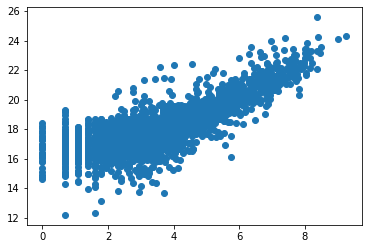

In [21]:
plt.scatter(np.log(joined['C24070_051E']), np.log(joined['amount']))

In [63]:
for i in range(10):
    print('Top: ', i, new_df['census_name'][i])


Top:  0 amount
Top:  1 PUBLIC HEALTH INSURANCE BY WORK EXPERIENCEEstimate!!Total:!!Worked less than full-time, year-round:!!No public coverage
Top:  2 PRIVATE HEALTH INSURANCE BY WORK EXPERIENCEEstimate!!Total:!!Worked full-time, year-round:!!No private health insurance
Top:  3 INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVEREstimate!!Total:!!Private not-for-profit wage and salary workers:!!Finance and insurance, and real estate, and rental and leasing
Top:  4 POVERTY STATUS IN THE PAST 12 MONTHS BY SEX BY AGEEstimate!!Total:!!Income in the past 12 months at or above poverty level:!!Female:!!65 to 74 years
Top:  5 SEX BY INDUSTRY FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVEREstimate!!Total:!!Female:!!Professional, scientific, and management, and administrative, and waste management services:!!Management of companies and enterprises
Top:  6 POVERTY STATUS IN THE PAST 12 MONTHS OF FAMILIES BY HOUSEHOLD TYPE BY NUMBER OF PERSONS IN FAMILYEstimate

In [71]:
print(new_df['census_name'][-10:])

4143    HEALTH INSURANCE COVERAGE STATUS AND TYPE BY C...
4144    INDUSTRY BY MEDIAN EARNINGS IN THE PAST 12 MON...
4145                                         B17001A_013E
4146    POVERTY STATUS IN THE PAST 12 MONTHS OF INDIVI...
4147    RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...
4148    HEALTH INSURANCE COVERAGE STATUS AND TYPE BY A...
4149    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...
4150    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...
4151    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...
4152    INDUSTRY BY CLASS OF WORKER FOR THE CIVILIAN E...
Name: census_name, dtype: object


In [30]:
data = copy.copy(joined)

In [54]:
from sklearn import linear_model

#x = data.select_dtypes(exclude=['object'])
x = data.loc[:,['C27014_007E', 'C27013_004E','C24070_051E', 'B17001_058E', 'C24030_046E',
                'B17013_006E', 'C24040_046E', 'B17013_007E', 'C27014_002E', 'B17001_049E',
                'C24050_028E', 'C24030_055E', 'B08126_014E', 'C24050_014E', 'C24070_014E', 
                'B08126_029E', 'C24050_056E', 'C24070_070E', 'C24040_055E', 'B17013_007E']]#,
                #'population',]]
#x = x.apply(lambda x: np.log(x++0.0001))
#x = np.asarray(x)
y = np.asarray(data['amount']).reshape(-1,1)

print(x.shape)
print(y.shape)

from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
import plotly
x_array = np.asarray(x)
normalized_arr = preprocessing.normalize(x_array)
df_norm= pd.DataFrame(x_array)

pca = PCA(n_components=7, svd_solver='full')
pca.fit(df_norm)
print(pca.components_)
print(pca.explained_variance_ratio_)
print(len(pca.components_[0]))

model = linear_model.LinearRegression().fit(x, y)

yhat = model.predict(x)
pred_error = np.sqrt(np.mean(np.subtract(yhat, y)**2))
print("Avg prediction error: ", pred_error)


X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

'''
spector_data = sm.datasets.spector.load(as_pandas=False)

spector_data.exog = sm.add_constant(spector_data.exog, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(spector_data.endog, spector_data.exog)
res = mod.fit()
'''

(2970, 20)
(2970, 1)
[[ 3.87190319e-03  1.34391369e-02  2.45765734e-02  8.41339492e-02
   6.46869025e-03  3.69005069e-02  5.57586697e-03  2.71364422e-01
   1.97522801e-01  4.12902388e-01  1.55457530e-01  1.64453298e-01
   3.46153689e-01  3.52242493e-01  3.52242493e-01  2.59692520e-01
   6.54572269e-02  3.52242493e-01  1.37560412e-01  2.71364422e-01]
 [ 5.92243422e-03  7.24596067e-03  8.73387832e-03  9.44938580e-02
   7.24818144e-03  4.83211399e-02  6.52335918e-03  4.01283522e-01
   2.21079571e-01  4.99964207e-01 -1.69148377e-01 -8.92234786e-02
  -2.55325427e-01 -2.56732232e-01 -2.56732232e-01 -2.44194690e-01
  -3.47480555e-02 -2.56732232e-01 -8.51107819e-02  4.01283522e-01]
 [ 3.81136541e-02  1.03158881e-02  3.80032099e-03 -2.67951953e-02
   2.51113909e-03  1.58410705e-03  2.18475312e-03 -1.27181069e-01
   9.48530922e-01 -2.34804234e-01  8.51010915e-02 -7.06869573e-03
  -1.17545628e-02 -1.63267141e-02 -1.63267141e-02 -4.43806345e-02
  -1.06548746e-02 -1.63267141e-02  1.37021333e-02 -1.

'\nspector_data = sm.datasets.spector.load(as_pandas=False)\n\nspector_data.exog = sm.add_constant(spector_data.exog, prepend=False)\n\n# Fit and summarize OLS model\nmod = sm.OLS(spector_data.endog, spector_data.exog)\nres = mod.fit()\n'

In [51]:
import plotly
from plotly.graph_objs import Bar, Line
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs.scatter import Marker
from plotly.graph_objs.layout import XAxis, YAxis
plot_explained_variance(pca)

In [9]:
from sklearn import linear_model

y = np.asarray(data['log amount']).reshape(-1,1)
x=np.asarray(data['log population']).reshape(-1,1)

model = linear_model.LinearRegression().fit(x, y)

yhat = model.predict(x)
pred_error = np.sqrt(np.mean(np.subtract(yhat, y)**2))
print("Avg prediction error: ", pred_error)

outlying = np.zeros((len(data.index)))

for i in range(len(data.index)):
    #print(i)
    #print(data.iloc[i,:], "yhat: ",yhat[i])
    #print(y[i])
    if y[i]>= yhat[i] + 3*pred_error:
        outlying[i] = 1
    elif y[i]< yhat[i]-3*pred_error:
        outlying[i]=-1

plt.hist(outlying)

NameError: name 'data' is not defined

In [152]:
KL_df.sort_values('KL_Divergence')

NameError: name 'KL_df' is not defined

In [ ]:
def identify_outlier_counties(joined):
    

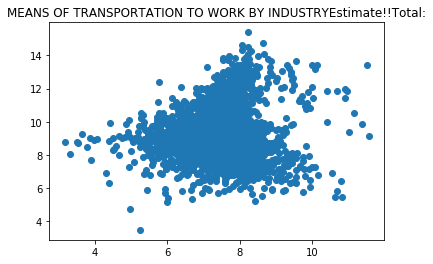

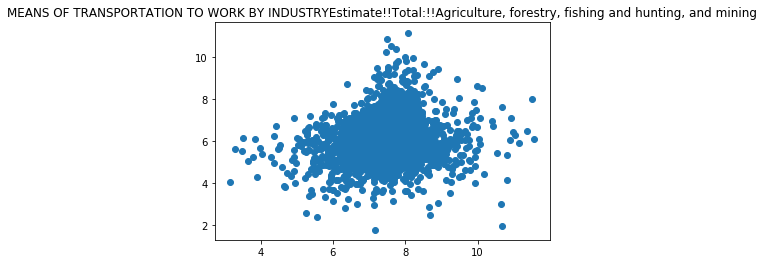

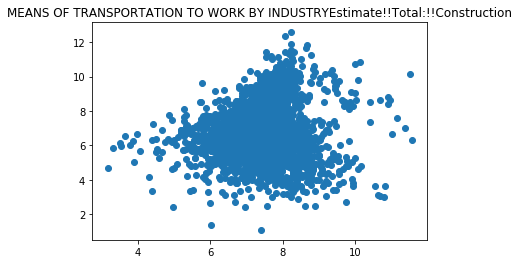

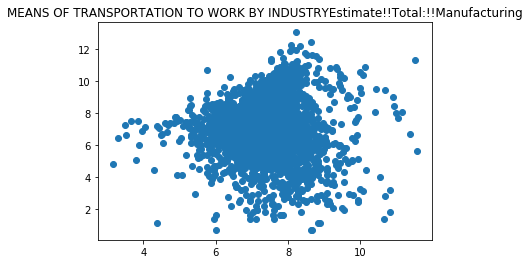

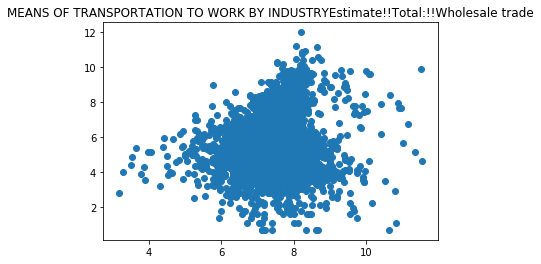

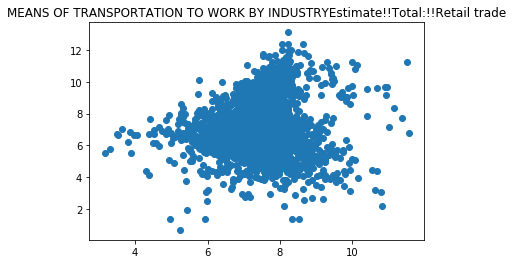

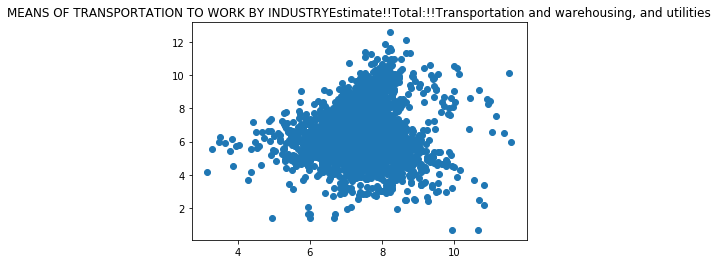

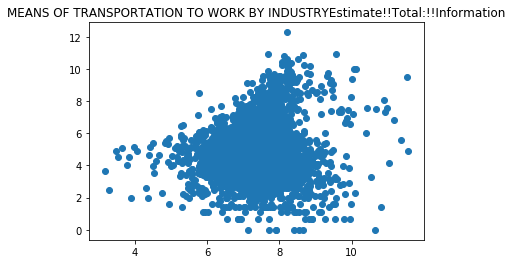

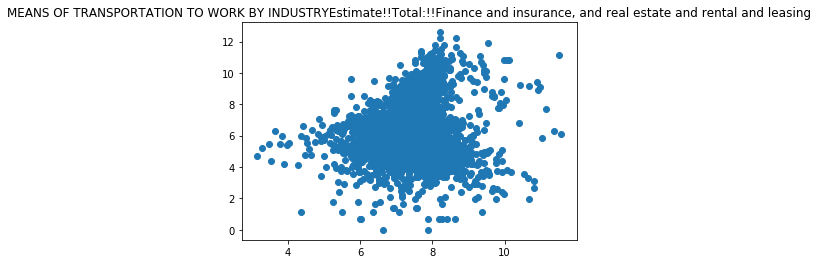

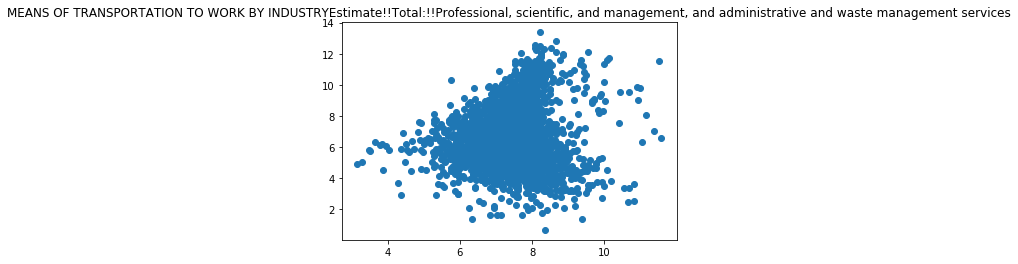

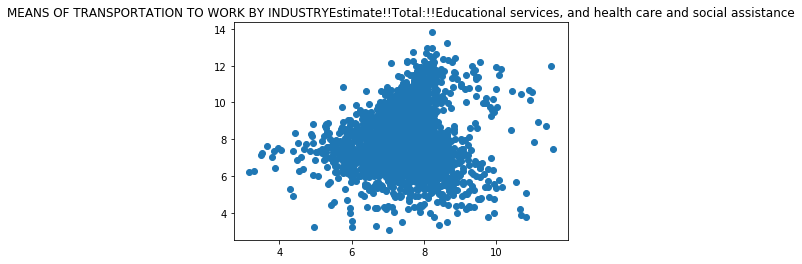

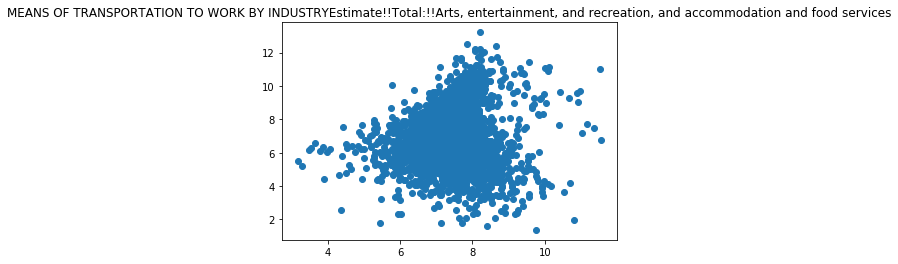

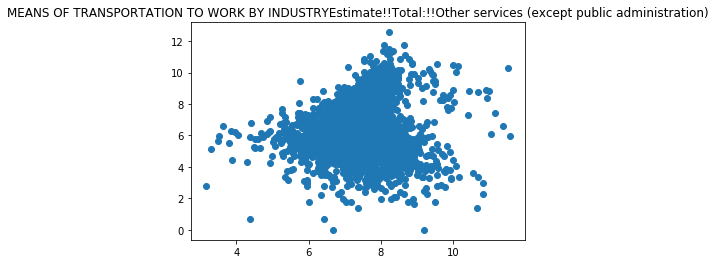

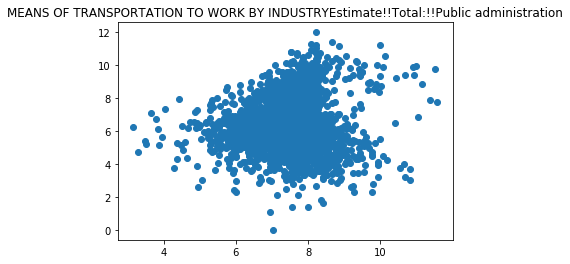

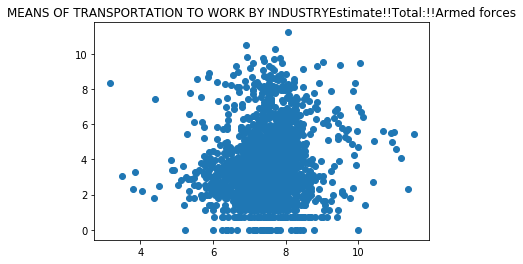

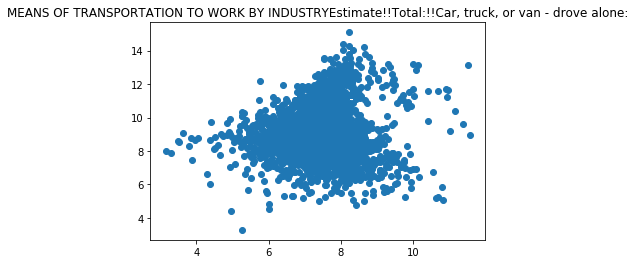

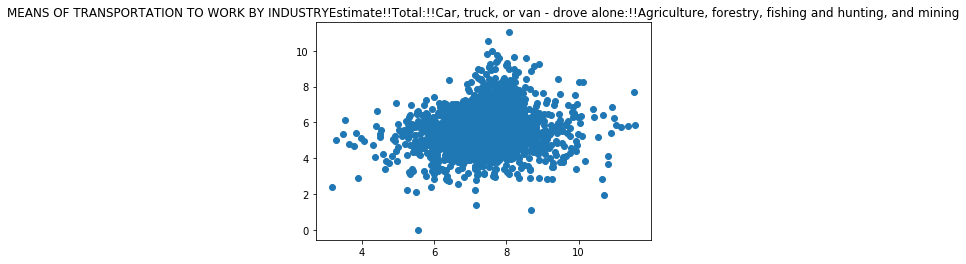

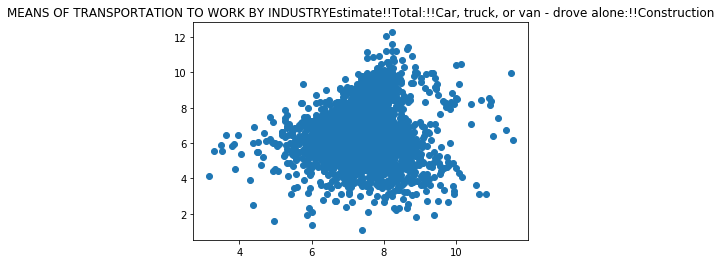

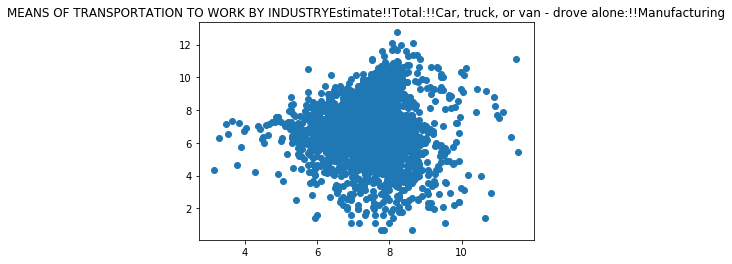

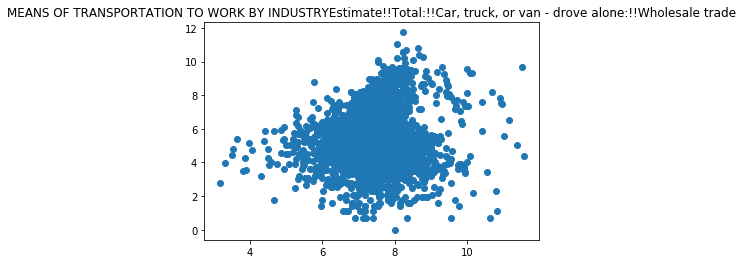

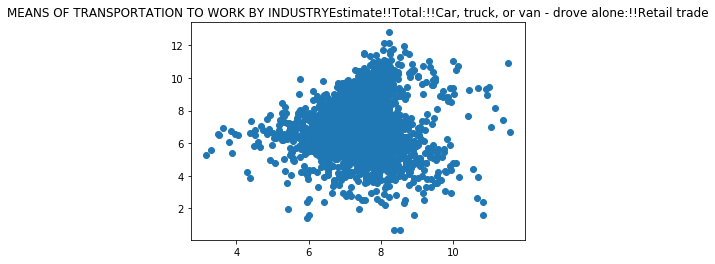

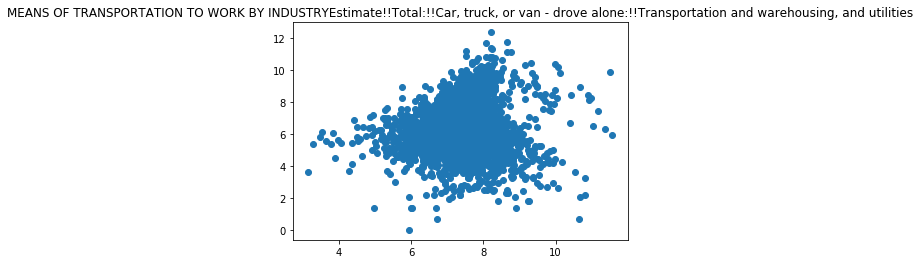

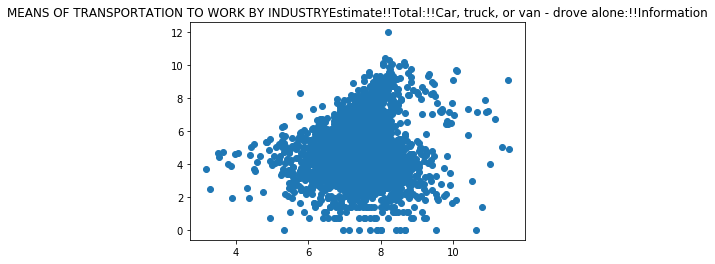

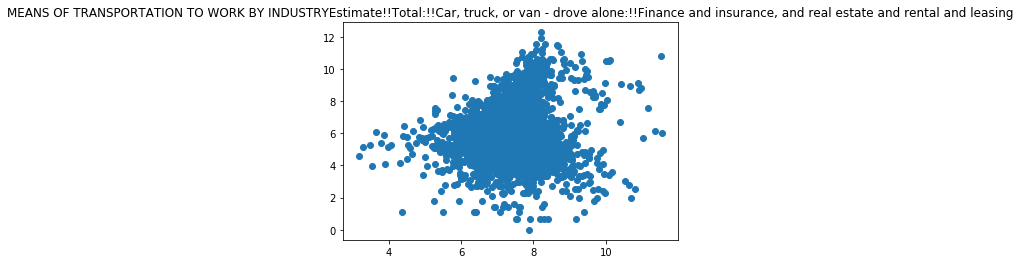

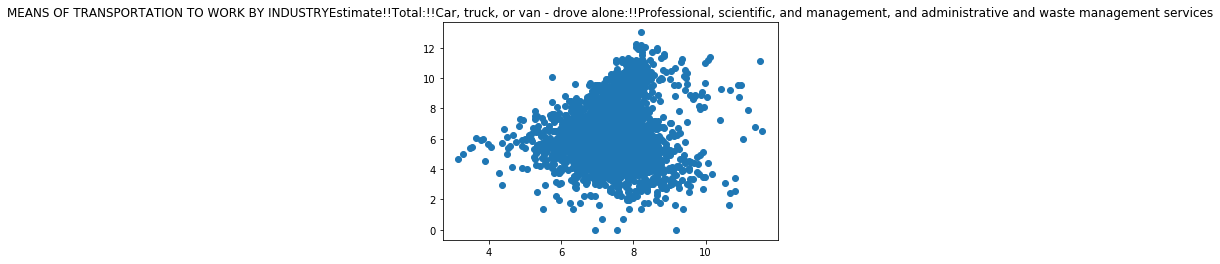

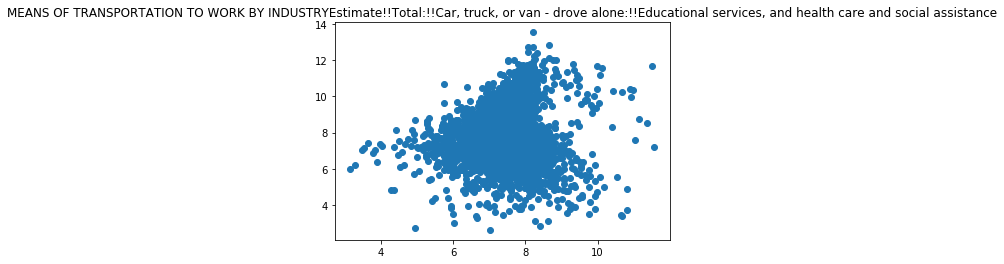

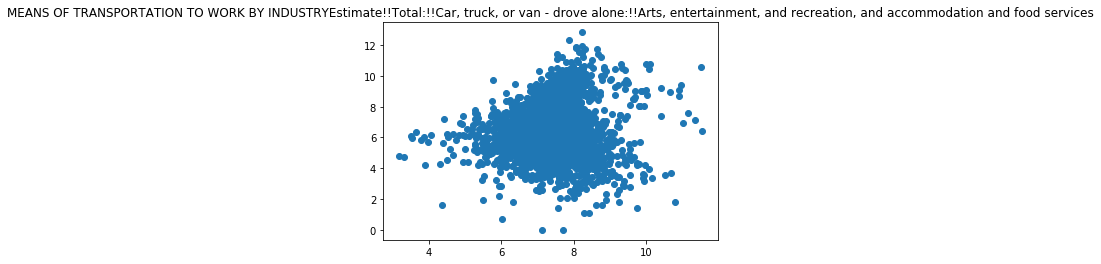

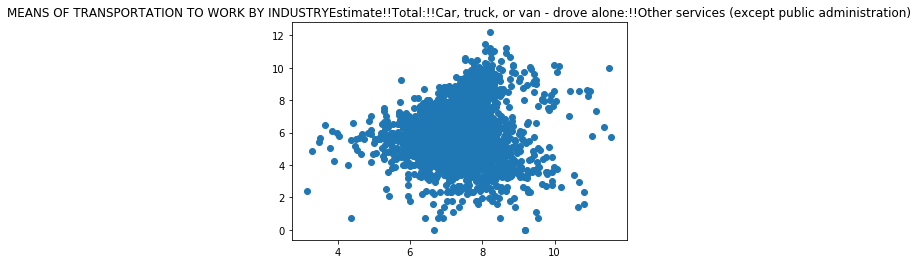

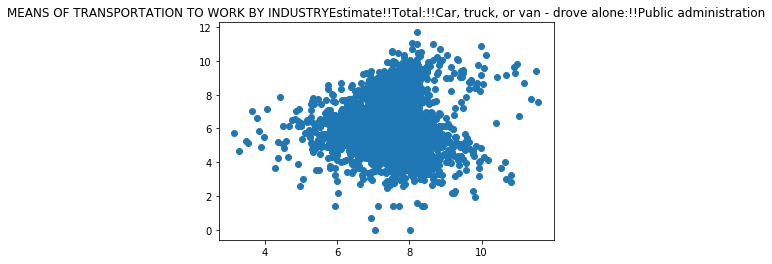

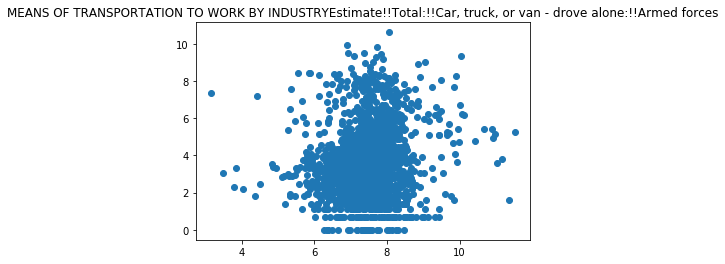

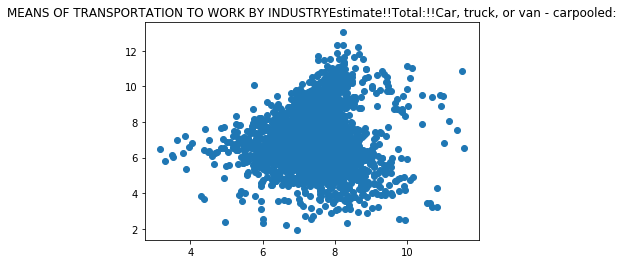

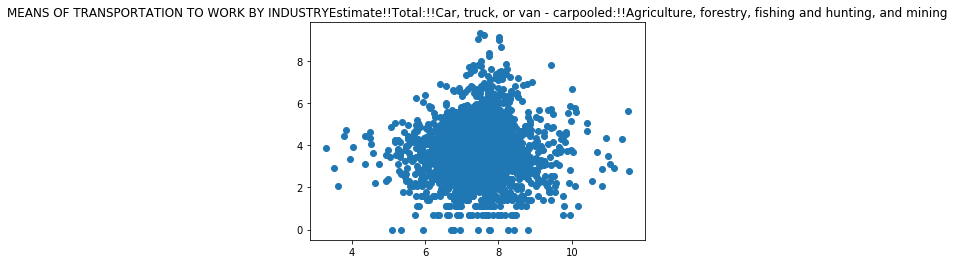

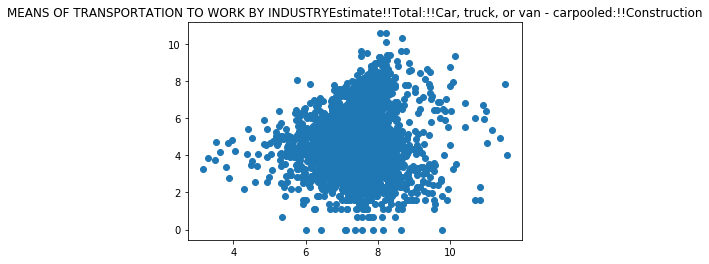

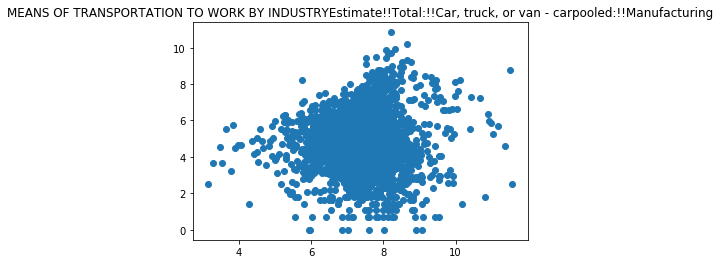

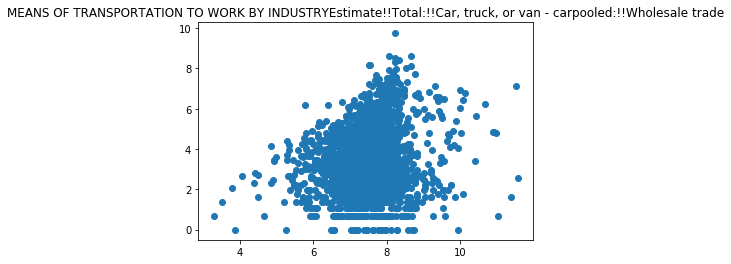

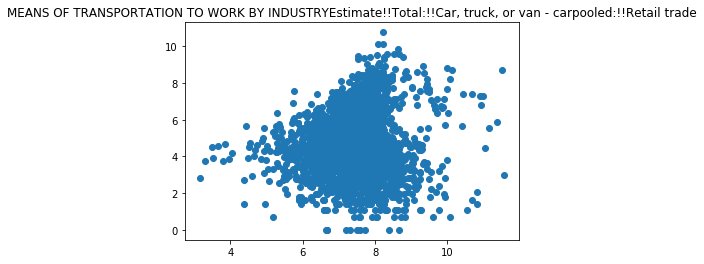

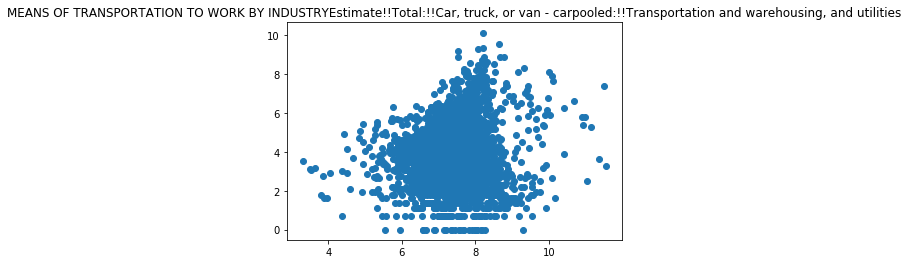

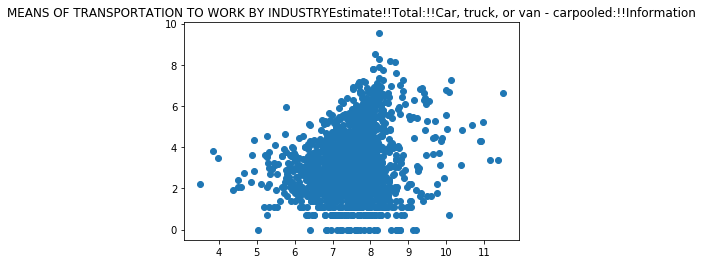

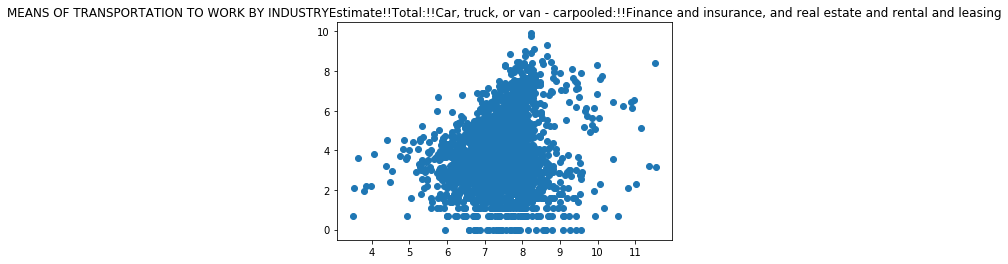

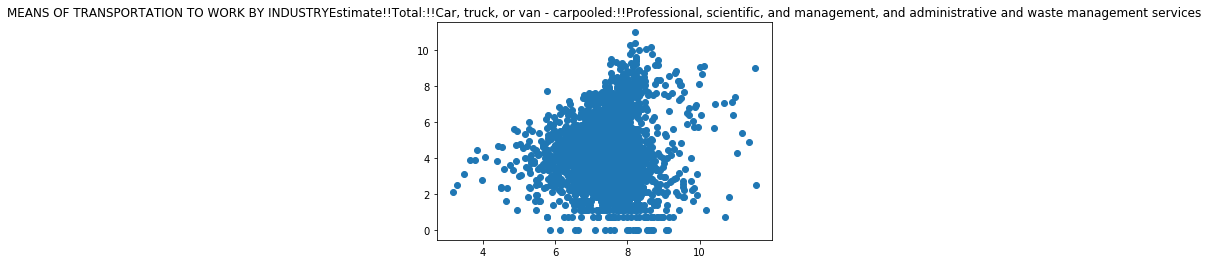

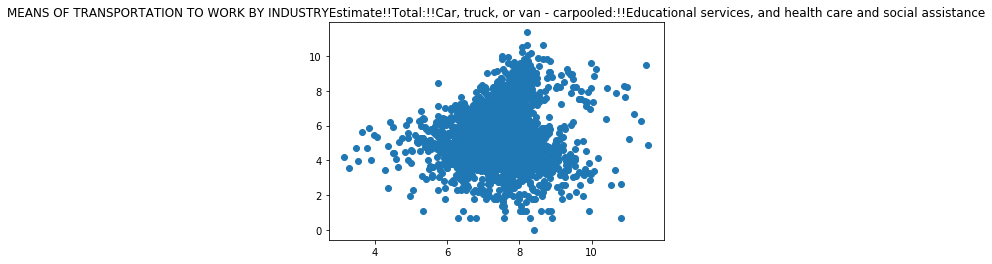

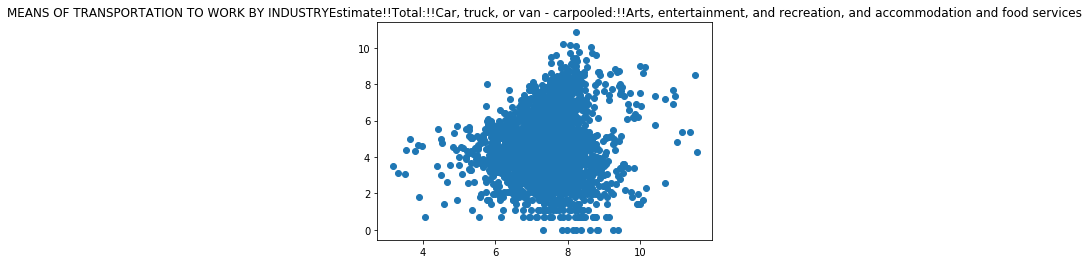

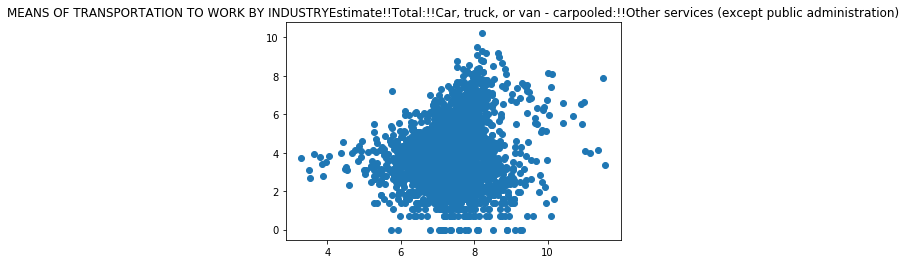

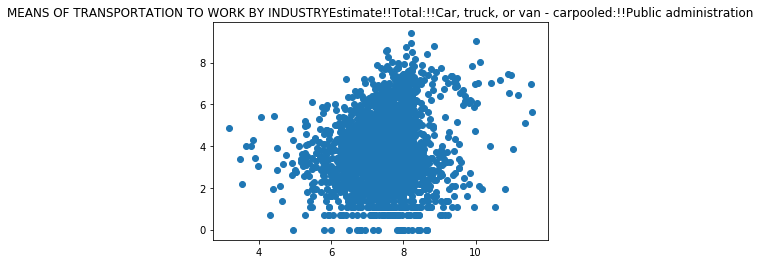

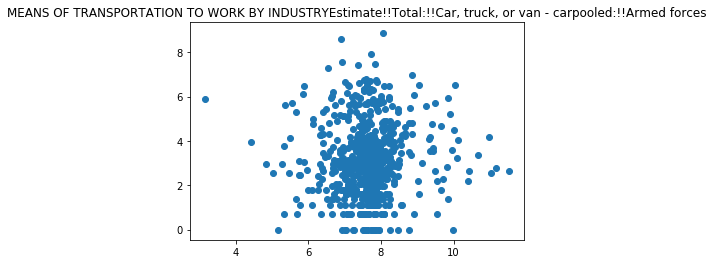

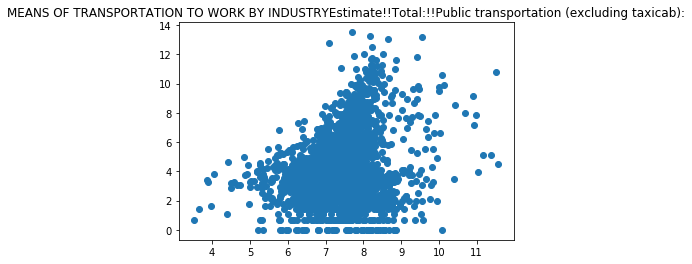

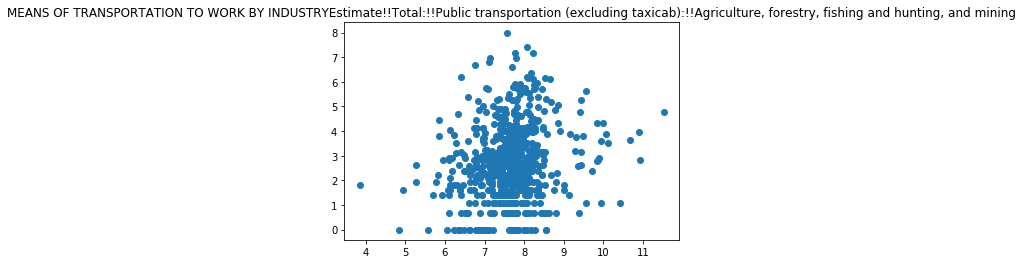

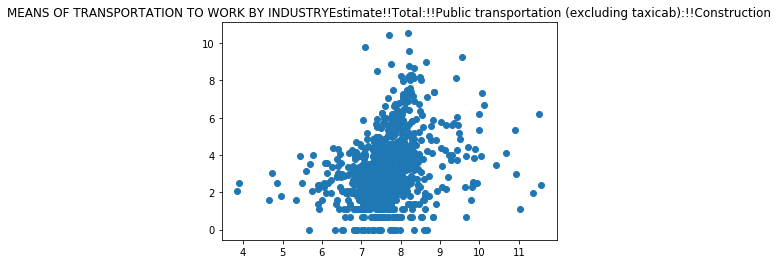

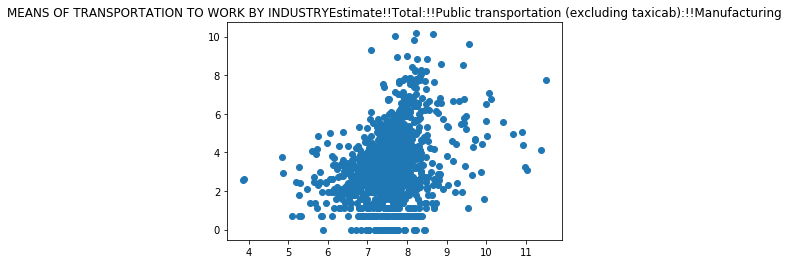

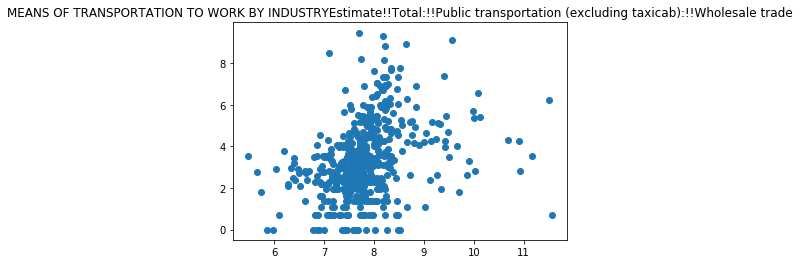

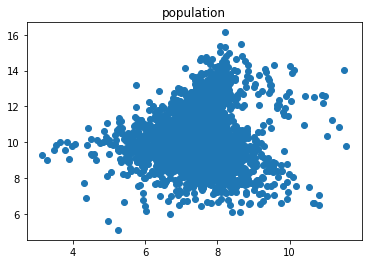

In [24]:
explore_plots(my_df)